# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [24]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features=1, min_leaf=1):
        self.X = X
        self.y = y 
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        if n_features <= 1:
            self.n_features = round(X.shape[1] * n_features)
        else:
            self.n_features = n_features
        self.min_leaf = min_leaf
        self.trees = []
        self.oob_total_idxs = np.arange(X.shape[0])

        self._fit(X, y)


    def _fit(self, X, y):

        for _ in range(self.n_trees):
            
            # randomly choose raws for tree
            selected_raws = np.random.choice(X.shape[0], size=self.sample_sz, replace=True)
            selected_features = sorted(np.random.choice(X.shape[1], size=self.n_features, replace=False))

            inbag_sample = X[selected_raws][:,selected_features]
            inbag_target = y[selected_raws]

            # calculate raws in oob
            self.oob_total_idxs = np.setdiff1d(self.oob_total_idxs, selected_raws)
            
            tree = DecisionTreeRegressor(min_samples_leaf=self.min_leaf)
            
            # fit tree and save it in self.trees
            tree.fit(inbag_sample, inbag_target)
            self.trees.append(tree)

        #print(self.oob_total_idxs)


    def predict(self, X):
        
        # predict with each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = predictions.mean(axis=0)
        
        return tree_preds


    def oob_mse(self):
        
        # check if there raws in oob
        if not self.oob_total_idxs.size:
            return "Out-of-bag set is empty"
        else:
            # oob set
            y_oob = self.y[self.oob_total_idxs]
            
            # make prediction and extract oob
            y_pred = self.predict(self.X)
            y_pred_oob = y_pred[self.oob_total_idxs]

            oob_mse = np.mean((y_oob - y_pred_oob) ** 2)
            
            return oob_mse



In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]


In [4]:
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf=min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

n_trees:1, sz:50, min_leaf:1 --- oob mse: 62.062527233115475
n_trees:1, sz:50, min_leaf:5 --- oob mse: 28.537207526877708
n_trees:1, sz:100, min_leaf:1 --- oob mse: 50.080602409638544
n_trees:1, sz:100, min_leaf:5 --- oob mse: 22.723825520560787
n_trees:1, sz:300, min_leaf:1 --- oob mse: 24.17738970588235
n_trees:1, sz:300, min_leaf:5 --- oob mse: 22.752273132566245
n_trees:1, sz:500, min_leaf:1 --- oob mse: 22.80820652173913
n_trees:1, sz:500, min_leaf:5 --- oob mse: 22.599073207095717
n_trees:5, sz:50, min_leaf:1 --- oob mse: 25.05625928338762


n_trees:5, sz:50, min_leaf:5 --- oob mse: 22.8123045058093
n_trees:5, sz:100, min_leaf:1 --- oob mse: 12.306414507772018
n_trees:5, sz:100, min_leaf:5 --- oob mse: 32.73417477317369
n_trees:5, sz:300, min_leaf:1 --- oob mse: 8.01924137931034
n_trees:5, sz:300, min_leaf:5 --- oob mse: 28.03806613435189
n_trees:5, sz:500, min_leaf:1 --- oob mse: 16.11336000000001
n_trees:5, sz:500, min_leaf:5 --- oob mse: 4.071664089380193
n_trees:10, sz:50, min_leaf:1 --- oob mse: 15.548947938144329
n_trees:10, sz:50, min_leaf:5 --- oob mse: 17.980206457159174
n_trees:10, sz:100, min_leaf:1 --- oob mse: 18.43887777777778
n_trees:10, sz:100, min_leaf:5 --- oob mse: 31.87190420334585
n_trees:10, sz:300, min_leaf:1 --- oob mse: 1.416100000000003
n_trees:10, sz:300, min_leaf:5 --- oob mse: Out-of-bag set is empty
n_trees:10, sz:500, min_leaf:1 --- oob mse: Out-of-bag set is empty
n_trees:10, sz:500, min_leaf:5 --- oob mse: Out-of-bag set is empty
n_trees:20, sz:50, min_leaf:1 --- oob mse: 13.224642361111105

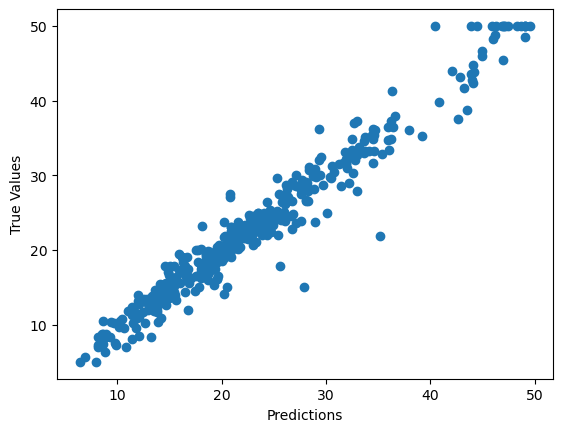

In [5]:
forest = TreeEnsemble(X, y, 20, 300, min_leaf=1)
y_hat = forest.predict(X) 
plt.scatter(y_hat, y)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.show()

## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





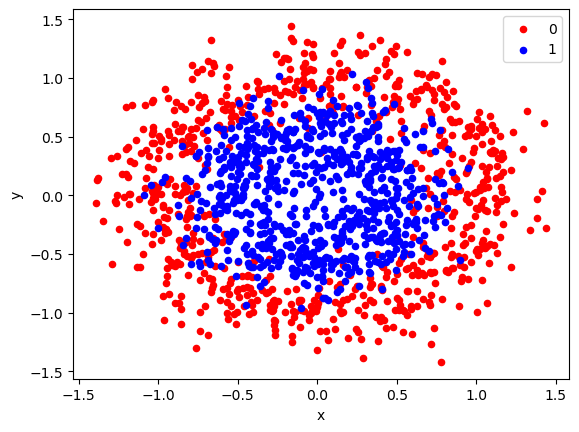

In [5]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [7]:
class AdaBooster():
    def __init__ (self, n_learners):
        self.n_learners = n_learners
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        y_f = y.copy()
        y_f[y_f==0] = -1
        for i in range(self.n_learners):

            if i == 0: # equal weights for each entry
                w = np.ones(len(y_f)) * 1/(len(y_f))

            else: # update weights and normalize
                a_sign = [x if x>0 else -1 for x in np.not_equal(y_pred, y_f).astype('int')]
                w = w * np.exp(alpha * np.array(a_sign)) 
                # w = w * np.exp(alpha * y_f *  y_pred) 
                w = w / np.sum(w)                


            self.w = w
            tm = DecisionTreeClassifier(max_depth=1)
            tm.fit(X, y_f,sample_weight=w)
            y_pred = tm.predict(X)
            self.models.append(tm)

            err = self._total_err(w, y_f, y_pred)
            if err > 0.5:
                y_pred = y_pred * (-1)
            alpha = self._alpha(err)

            self.alphas.append(alpha)

    def _total_err(self, w, y, y_pred):
        return np.sum(w * np.not_equal(y, y_pred)) 
    
    def _alpha(self, err):
        return 0.5 * np.log((1-err)/(err + 1e-10))

    def predict(self, X):
        predictions = np.zeros(len(X))
        for m, a in zip(self.models, self.alphas):
            predictions += m.predict(X) * a
        res = np.vectorize(lambda x: 1 if x > 0 else 0)
        return res(predictions)



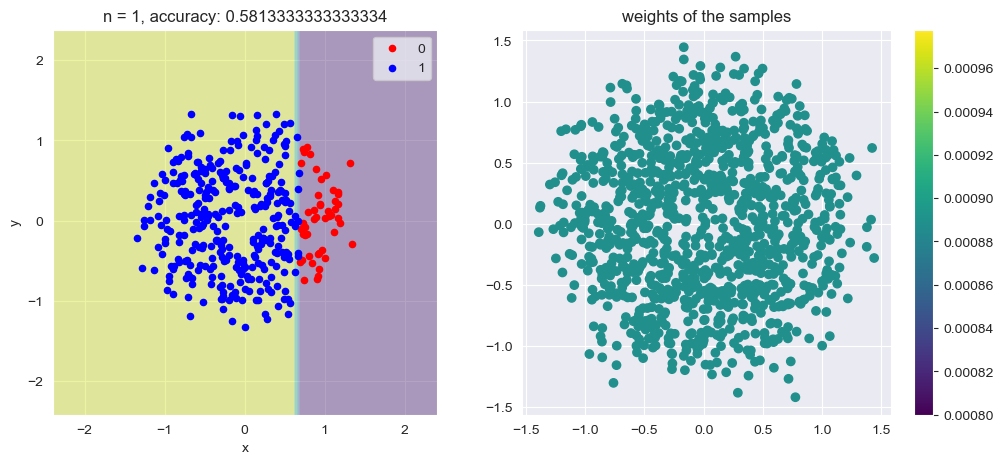

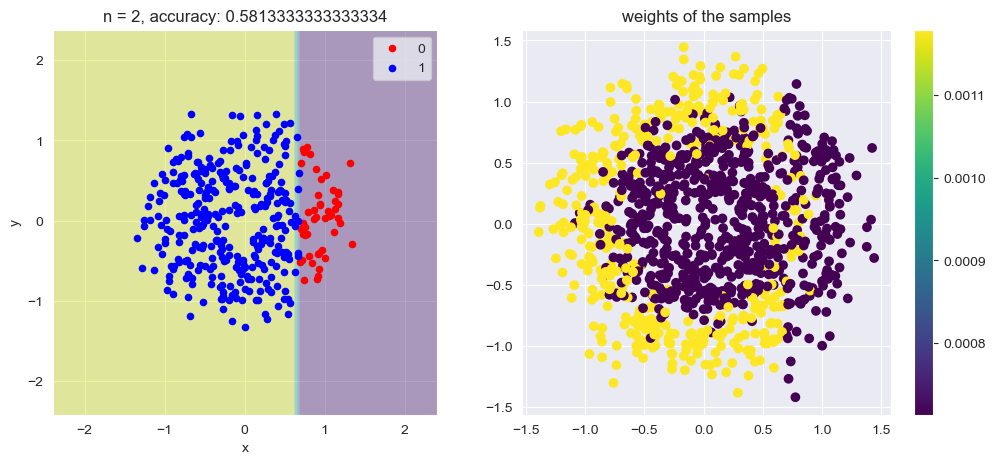

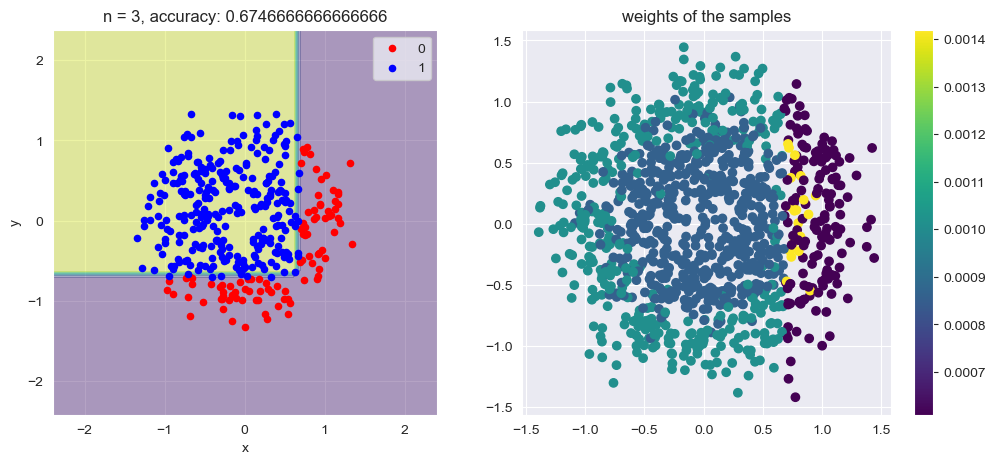

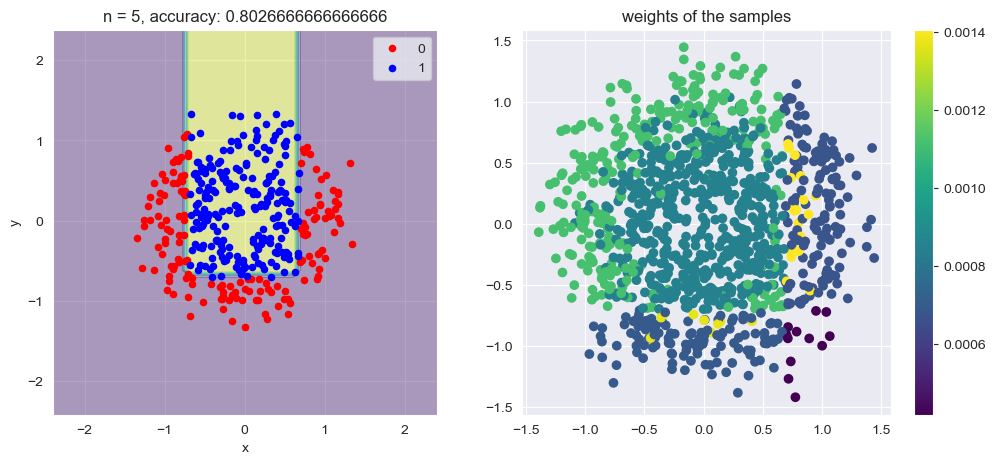

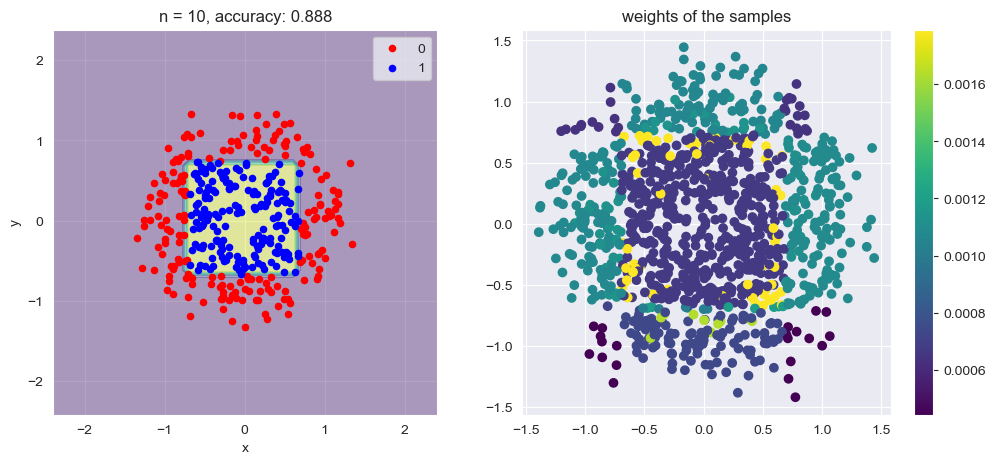

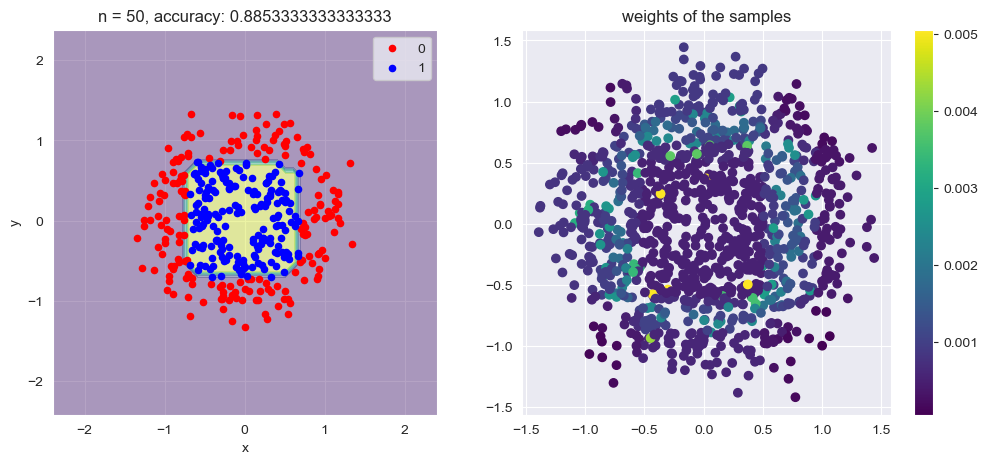

In [24]:
# 2.2.2. Split the sample set into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29)

# 2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, 
# and visualize the final iteration weights of the samples in those plots.

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

for n in [1, 2, 3, 5, 10, 50]:
    tm = AdaBooster(n)
    tm.fit(X_train, y_train)
    y_pred = tm.predict(X_test)
    # print('accuracy:', accuracy_score(y_test, y_pred))


    # Predictions for the mesh grid
    Z = tm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # scatter plot, dots colored by class value
    df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
    colors = {0:'red', 1:'blue'}
    # fig, ax = pyplot.subplots()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})


    ax = axs[0]
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax.set_title(f'n = {n}, accuracy: {accuracy_score(y_test, y_pred)}')

    ax = axs[1]
    sc = plt.scatter(x=X_train[:,0], y=X_train[:,1], c=tm.w, cmap='viridis')
    plt.title('weights of the samples')
    plt.colorbar(sc, ax=ax)    
    pyplot.show()

The accuracy increases as the number of weak learners in the AdaBoost algorithm rises from 1 to 50. This suggests that the model benefits from more weak learners in capturing complex decision boundaries. 

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [32]:
# Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.

class L2Boost():
    def __init__(self, n_trees=200, eta=0.05, max_depth=1): #X, y, 
        # self.y = y
        self.n_trees = n_trees
        self.eta = eta
        self.f = 0
        self.models = []
        self.mean_v = None
        self.max_depth = max_depth
        self.y = None
        
        # self.f = self._fit(X, y)

    def fit(self, X, y):
        self.y = y
        self.f = np.mean(self.y)

        for m in range(self.n_trees):
            r = self.y - self.f
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, r)
            self.models.append(tree)
            r_pred = tree.predict(X)
            self.f += self.eta * r_pred

        return self.f
    
    def predict(self, X):
        pred = np.mean(self.y)
        for model in self.models:
            pred += self.eta * model.predict(X)
        
        return pred


    def mse(self):
        mse = np.mean((self.y - self.f) ** 2)
        return mse


In [42]:
# 2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?

# load boston
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)




In [ ]:
# Define the range of number of trees
n_trees_range = np.logspace(0, 3, num=50, dtype=int)

mse_values_train = []
mse_values_test = []

for n_trees in n_trees_range:
    model = L2Boost(n_trees=n_trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_values_train.append(model.mse())
    mse_values_test.append(mean_squared_error(y_pred, y_test))


# Define the range of learning rate
eta_range = np.arange(0.001, 2, 0.05)
n_trees=200
mse_values_train_eta = []
mse_values_test_eta = []

for eta in eta_range:
    model = L2Boost(eta=eta)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_values_train_eta.append(model.mse())
    mse_values_test_eta.append(mean_squared_error(y_pred, y_test))

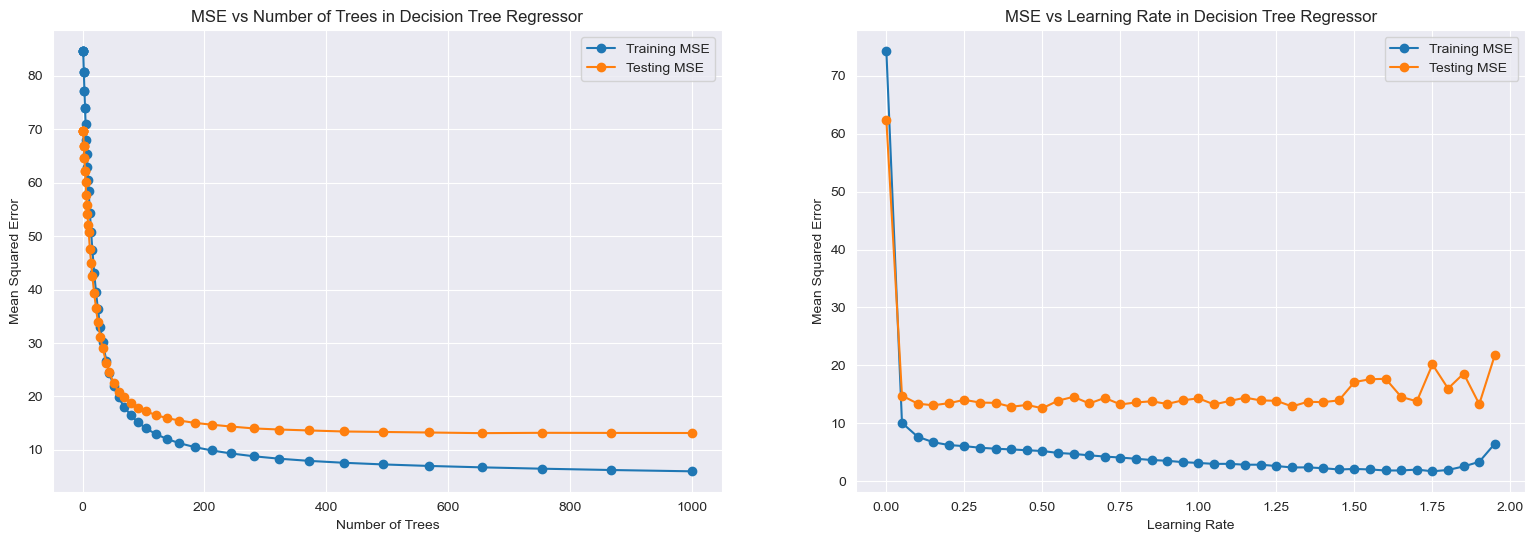

In [44]:
plt.figure(figsize=(19, 6))

# Plotting the MSE as a function of the number of trees

plt.subplot(1, 2, 1)
sns.set_style('darkgrid')
plt.plot(n_trees_range, mse_values_train, marker='o', linestyle='-', label='Training MSE')
plt.plot(n_trees_range, mse_values_test, marker='o', linestyle='-', label='Testing MSE')
#plt.xscale('log')
plt.title('MSE vs Number of Trees in Decision Tree Regressor')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()


# Plotting the MSE as a function of the learning rate

plt.subplot(1, 2, 2)
sns.set_style('darkgrid')
plt.plot(eta_range, mse_values_train_eta, marker='o', linestyle='-', label='Training MSE')
plt.plot(eta_range, mse_values_test_eta, marker='o', linestyle='-', label='Testing MSE')
#plt.xscale('log')
plt.title('MSE vs Learning Rate in Decision Tree Regressor')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()

plt.show()

<u>What is the optimal value of `n_trees`? of learning rate?</u>

The optimal value of n_trees in our case could be around 200, as this is the point where the benefit of adding more trees diminishes and before the MSE levels off completely. It is important to consider that increasing n_trees also increases the computational cost, so it is practical to choose a value that balances error reduction with computational efficiency.

The optimal learning rate is about 0.15. Beyond this point, the MSE starts to plateau and even slightly increase, especially after a learning rate of 1.5.

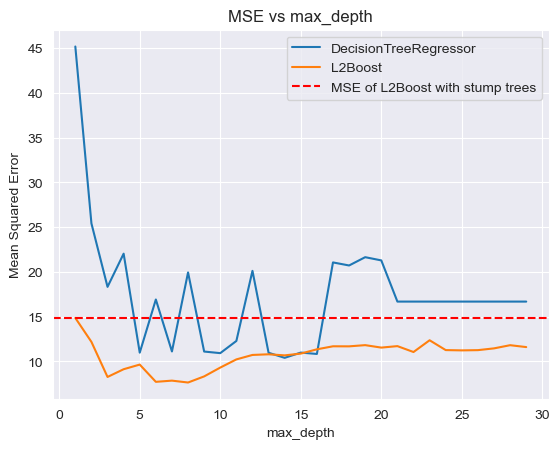

In [56]:
# 3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?

mse_dtr, mse_l2b = [], []
max_depths = range(1, 30)

for md in max_depths:    

    # DecisionTreeRegressor
    model_dtr = DecisionTreeRegressor(max_depth=md, random_state=42)
    model_dtr.fit(X_train, y_train)
    pred_dtr = model_dtr.predict(X_test)
    mse_dtr.append(mean_squared_error(pred_dtr, y_test))

    # L2Boost
    model_l2b = L2Boost(max_depth=md)
    model_l2b.fit(X_train, y_train)
    pred_l2b = model_l2b.predict(X_test)
    mse_l2b.append(mean_squared_error(pred_l2b, y_test))

plt.figure()

plt.plot(max_depths, mse_dtr, label='DecisionTreeRegressor')
plt.plot(max_depths, mse_l2b, label='L2Boost')

# Plot horizontal line for MSE of L2Boost with stump trees
plt.axhline(y=mse_l2b[0], color='r', linestyle='--', label='MSE of L2Boost with stump trees')

plt.title('MSE vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()


From the graph we see that DecisionTreeRegressor often shows better results compared to L2Boost with stump trees. But if we increase the maximum depth of L2Boost trees, it yields better MSE than DecisionTreeRegressor.

In [60]:
# 4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

class L2Boost_es():
    def __init__(self, n_trees, eta, max_depth=1): #X, y, 
        # self.y = y
        self.n_trees = n_trees
        self.eta = eta
        #self.f = np.zeros_like(y)
        self.models = []
        self.mean_v = None
        self.max_depth = max_depth
        
        # self.f = self._fit(X, y)

    def fit(self, X, y, val_iters = 5):

        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        self.y = y
        val_scores = []
        best_mse = None
        best_iteration = 0

        f = np.mean(y)
        self.mean_v = f
        for m in range(self.n_trees):
            r = y - f
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, r)
            self.models.append(tree)
            r_pred = tree.predict(X)
            f += self.eta * r_pred

            # validation step
            val_pred = self.predict(X_val)
            val_mse = np.mean((y_val - val_pred) ** 2)
            val_scores.append(val_mse)

            best_mse = val_mse if best_mse is None else best_mse

            # early stopping check
            
            if val_mse < best_mse:
                best_mse = val_mse
                best_iteration = m
            elif (m - best_iteration) >= val_iters:
                print(f"Early stopping at iteration {m}")
                break

        # Remove the extra trees added after the best iteration
        self.models = self.models[:best_iteration + 1]
        self.f = self.predict(X)  # Recalculate the predictions on training set
        return self.f
    
    
    def predict(self, X):
        pred = self.mean_v
        for model in self.models:
            pred += self.eta * model.predict(X)
        
        return pred


    def mse(self):
        mse = np.mean((self.y - self.f) ** 2)
        return mse


In [65]:
# check early stopping

# Define the range of number of trees
n_trees_range = np.logspace(0, 3, num=20, dtype=int)

mse_values_train = []
mse_values_test = []

for n_trees in n_trees_range:
    model = L2Boost_es(n_trees, 0.05)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_values_train.append(model.mse())
    mse_values_test.append(mean_squared_error(y_pred, y_test))


# Define the range of learning rate
eta_range = np.arange(0.001, 2, 0.05)
n_trees=200
mse_values_train_eta = []
mse_values_test_eta = []

for eta in eta_range:
    model = L2Boost_es(n_trees, eta)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_values_train_eta.append(model.mse())
    mse_values_test_eta.append(mean_squared_error(y_pred, y_test))

Early stopping at iteration 258
Early stopping at iteration 258
Early stopping at iteration 258
Early stopping at iteration 258
Early stopping at iteration 150
Early stopping at iteration 58
Early stopping at iteration 37
Early stopping at iteration 45
Early stopping at iteration 38
Early stopping at iteration 28
Early stopping at iteration 45
Early stopping at iteration 12
Early stopping at iteration 18
Early stopping at iteration 11
Early stopping at iteration 47
Early stopping at iteration 17
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 17
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 25
Early stopping at iteration 28
Early stopping at iteration 25
Early stopping at iteration 10
Early stopping at iteration 10
Early stopping at iteration 26
Early stopping at iteration 24
Early stopping at iteration 16
Early stopping at iteration 25
Early stopping at iteration 8
Early stopping at iteration 25
Earl

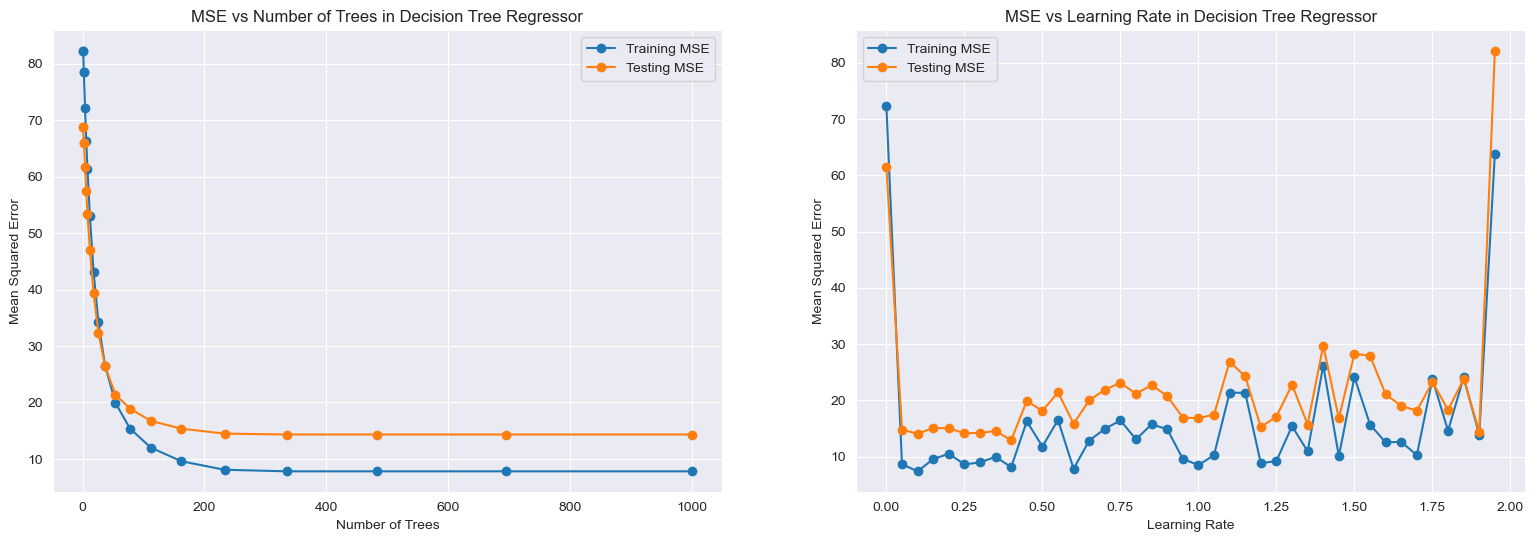

In [66]:
plt.figure(figsize=(19, 6))

# Plotting the MSE as a function of the number of trees

plt.subplot(1, 2, 1)
sns.set_style('darkgrid')
plt.plot(n_trees_range, mse_values_train, marker='o', linestyle='-', label='Training MSE')
plt.plot(n_trees_range, mse_values_test, marker='o', linestyle='-', label='Testing MSE')
#plt.xscale('log')
plt.title('MSE vs Number of Trees in Decision Tree Regressor')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()


# Plotting the MSE as a function of the learning rate

plt.subplot(1, 2, 2)
sns.set_style('darkgrid')
plt.plot(eta_range, mse_values_train_eta, marker='o', linestyle='-', label='Training MSE')
plt.plot(eta_range, mse_values_test_eta, marker='o', linestyle='-', label='Testing MSE')
#plt.xscale('log')
plt.title('MSE vs Learning Rate in Decision Tree Regressor')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()

plt.show()